In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [6]:
log_pr.head()

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2021-07-01 00:00:00,0.000051,-0.002754,-0.001690,-0.000106,0.002195,0.000217,-0.001661,0.000492,-0.000917,-0.000769
2021-07-01 00:01:00,-0.002184,-0.001334,0.000652,0.000254,0.000969,0.000204,-0.002689,0.001095,-0.000665,-0.000493
2021-07-01 00:02:00,-0.000792,0.001095,0.001293,0.000294,-0.003068,0.000814,-0.005329,0.000172,0.002367,0.000202
2021-07-01 00:03:00,-0.000399,0.000931,0.001274,-0.000695,-0.002457,0.000626,-0.002712,0.000216,0.003020,0.000335
2021-07-01 00:04:00,-0.001120,0.001134,0.001266,-0.000583,-0.003706,0.000280,-0.004193,0.000299,0.002340,0.000187


<AxesSubplot:xlabel='timestamp'>

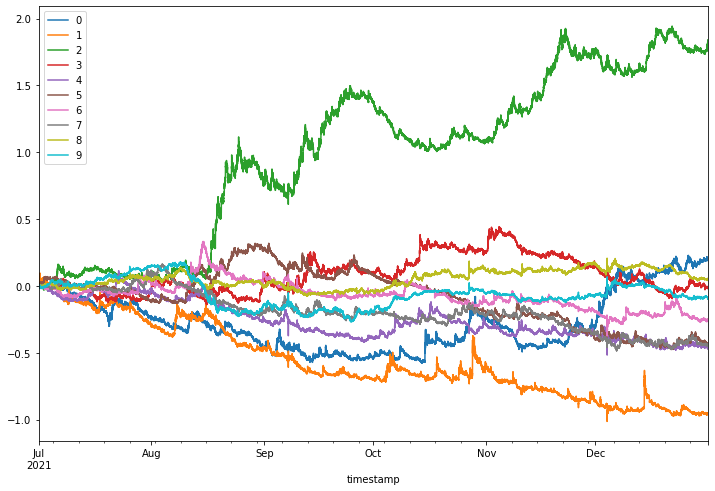

In [8]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

<AxesSubplot:xlabel='timestamp'>

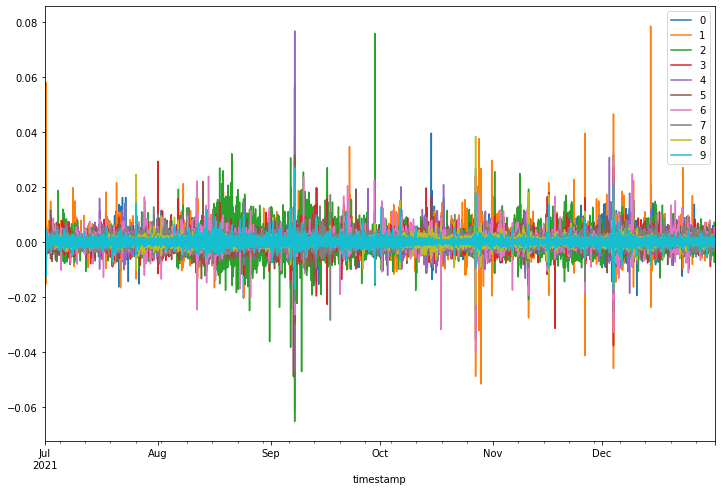

In [9]:
log_pr_diff = log_pr.diff()
log_pr_diff.plot(figsize=(12, 8))

In [8]:
log_pr_diff.head()

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2021-07-01 00:00:00,NaN,-0.002805,0.001065,0.001584,0.002301,-0.001978,-0.001878,0.002154,-0.001409,0.000148
2021-07-01 00:01:00,NaN,0.000850,0.001986,-0.000398,0.000715,-0.000765,-0.002892,0.003783,-0.001760,0.000172
2021-07-01 00:02:00,NaN,0.001887,0.000198,-0.000999,-0.003361,0.003882,-0.006143,0.005501,0.002195,-0.002165
2021-07-01 00:03:00,NaN,0.001330,0.000342,-0.001969,-0.001761,0.003083,-0.003338,0.002928,0.002804,-0.002685
2021-07-01 00:04:00,NaN,0.002254,0.000132,-0.001849,-0.003123,0.003986,-0.004473,0.004492,0.002041,-0.002153


In [4]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [5]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

11.311692953109741


In [6]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [7]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

0    0.028584
1    0.063681
2    0.005824
3    0.036314
4    0.096442
5    0.035261
6    0.067607
7    0.022329
8    0.105946
9    0.053176
dtype: float64

In [8]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

0.04011869454104755